<a href="https://colab.research.google.com/github/pavelpryadokhin/Regression/blob/main/Car_Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Прогноз цен на автомобили

Используя  [датасет](https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv) японских машин, обучим модель предсказывать цены на японские автомобили.

In [ ]:
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LeakyReLU
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential, Model
from keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2024-09-27 16:59:44--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv’

japan_cars_dataset. 100%[===================>] 133.53K   300KB/s    in 0.4s    

2024-09-27 16:59:45 (300 KB/s) - ‘japan_cars_dataset.csv’ saved [136735/136735]



#Обработка и очистка данных

Снизим уровень шума в каждой метрике и повысить корреляцию между характеристиками автомобиля и его продажной ценой.

In [ ]:
df = pd.read_csv('japan_cars_dataset.csv', sep=',')
df = df.dropna()
df.drop(['Unnamed: 0'],inplace=True, axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
0,489,honda,fit,2009,103465,1290,at,2wd,rhd,gasoline
1,940,mitsubishi,colt,2011,37000,1330,at,2wd,rhd,gasoline
2,1270,toyota,ist,2004,63000,1290,at,2wd,rhd,gasoline
3,1395,toyota,auris,2007,35000,1500,at,2wd,rhd,gasoline
4,390,nissan,cube,2011,97100,1500,at,2wd,rhd,gasoline
5,1110,toyota,vitz,2006,59266,1300,at,2wd,rhd,gasoline
6,1130,volkswagen,golf,2009,67000,1380,at,2wd,rhd,gasoline
7,1220,nissan,cube,2010,135000,1490,at,2wd,rhd,gasoline
8,1194,toyota,corolla spacio,2005,87904,1500,at,2wd,rhd,gasoline
9,1360,volkswagen,polo,2007,86000,1400,at,2wd,rhd,gasoline


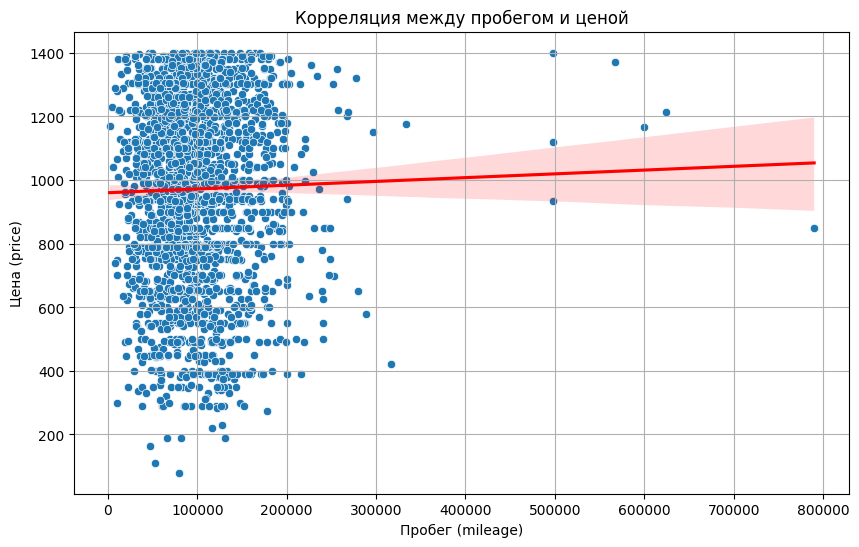

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='mileage', y='price')

sns.regplot(data=df, x='mileage', y='price', scatter=False, color='red')

plt.title('Корреляция между пробегом и ценой')
plt.xlabel('Пробег (mileage)')
plt.ylabel('Цена (price)')
plt.grid(True)

plt.show()

In [ ]:
df['mileage_range']=pd.cut(df['mileage'],
                         bins=[0,154000,300000],
                         labels=range(2),
                         include_lowest=True)

In [ ]:
df.loc[df['mileage'] >250000, 'mileage'] = df['mileage'].median()
df = df[df['price'] >= 200]

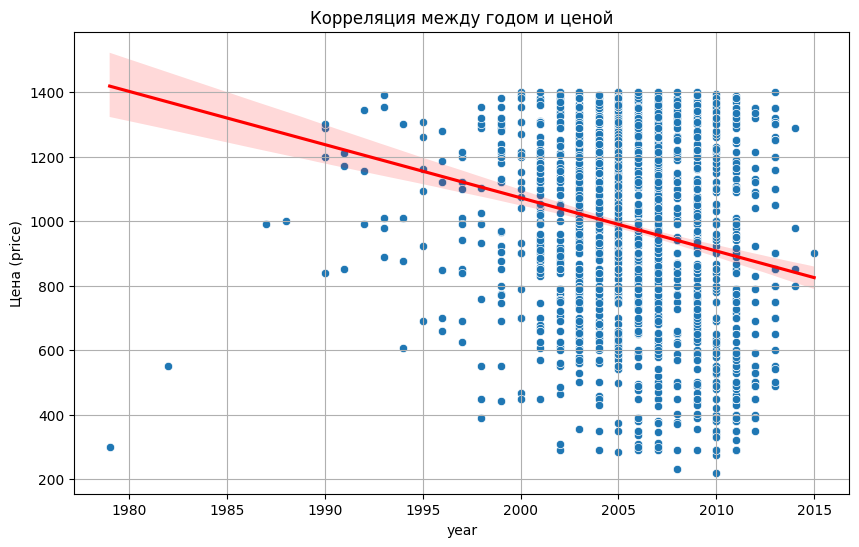

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='price')

sns.regplot(data=df, x='year', y='price', scatter=False, color='red')

plt.title('Корреляция между годом и ценой')
plt.xlabel('year')
plt.ylabel('Цена (price)')
plt.grid(True)

plt.show()

In [ ]:
df.loc[df['year'] <1989, 'year'] = df['year'].median()
df.loc[1458, 'price']=df['price'].median()
df['year_range']=pd.cut(df['year'],
                         bins=[1989, 1995, 2000, 2005, 2010, 2016],
                         labels=range(5),
                         include_lowest=True)

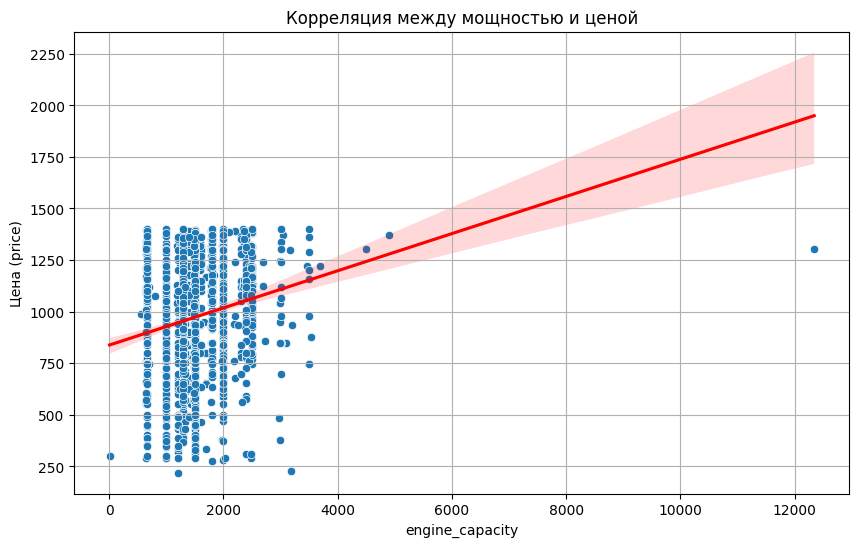

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='engine_capacity', y='price')

sns.regplot(data=df, x='engine_capacity', y='price', scatter=False, color='red')

plt.title('Корреляция между мощностью и ценой')
plt.xlabel('engine_capacity')
plt.ylabel('Цена (price)')
plt.grid(True)
# plt.xticks(df['engine_capacity'])
plt.show()

In [ ]:
df.loc[df['engine_capacity'] >3600, 'engine_capacity'] = df['engine_capacity'].median()
df.loc[df['engine_capacity'] <570, 'engine_capacity'] = df['engine_capacity'].median()
df.loc[(df['engine_capacity'] >2500) & (df['price'] <800), 'price']  = df[df['engine_capacity']>2500]['price'].median()
df.loc[(df['engine_capacity'] >2100) & (df['price'] <600), 'price']  = df[df['engine_capacity']<2500]['price'].median()
df.loc[(df['engine_capacity'] >1900) & (df['price'] <500), 'price']  = df[df['engine_capacity']<2500]['price'].median()
df.loc[(df['engine_capacity'] >1600) & (df['price'] <450), 'price']  = df[df['engine_capacity']<2500]['price'].median()
df.loc[(df['engine_capacity'] >1000) & (df['price'] <230), 'price']  = df[df['engine_capacity']<1000]['price'].median()


df['engine_capacity_range']=pd.cut(df['engine_capacity'],
                         bins=[0, 1504, 2040, 2600, 5000],
                         labels=range(4),
                         include_lowest=True)

In [ ]:
df.loc[(df['price'] < 800) & (df['transmission'] == 'cvt'), 'price']  = df[df['transmission']=='cvt']['price'].median()

df.loc[(df['price'] < 750) & (df['transmission'] == 'mt'), 'price']  = df[df['transmission']=='mt']['price'].median()
df.loc[(df['price'] < 200) & (df['transmission'] == 'at'), 'price']  = df[df['transmission']=='at']['price'].median()
df.loc[(df['price'] > 1000) & (df['transmission'] == 'at'), 'price']  = df[df['transmission']=='at']['price'].median()
df.loc[(df['price'] < 600) & (df['drive'] == '4wd'), 'price']  = df[df['drive']=='4wd']['price'].median()
df['fuel']=df['fuel'].replace('cng','diesel')
df['fuel']=df['fuel'].replace('lpg','diesel')
df['fuel']=df['fuel'].replace('hybrid','diesel')
df['hand_drive']=df['hand_drive'].replace('center','rhd')

Разделим на классы автомобили

In [ ]:
mark={
    'jaguar': 3,
    'hino': 4,
    'ford': 3,
    'hyundai': 4,
    'volvo': 3,
    'kia motors': 3,
    'bmw': 3,
    'isuzu': 2,
    'mitsuoka': 3,
    'citroen': 3,
    'land rover': 2,
    'volkswagen': 2,
    'peugeot': 3,
    'subaru': 3,
    'audi': 3,
    'toyota': 1,
    'suzuki': 1,
    'mazda': 1,
    'honda': 1,
    'smart': 1,
    'daihatsu': 1,
    'mitsubishi': 1,
    'nissan': 0,
    'mercedes-benz': 3,
    'opel': 0,
    'gm': 0,
    'chrysler':0,
    'kubota': 4
}

df['mark'] = df['mark'].map(mark)

In [ ]:
median_prices = df.groupby('model')['price'].mean().reset_index().sort_values(by='price')

bins = [0, 400,601,703,801,836,908,950,985,1001,1020, 1100,1170,1400]
labels = range(1, len(bins))

# Классификация по интервалам
median_prices['price_interval'] = pd.cut(median_prices['price'], bins=bins, labels=labels, right=False)


# Создание словаря, где ключ — модель, значение — номер интервала
model_to_interval = dict(zip(median_prices['model'], median_prices['price_interval']))
df['model'] = df['model'].map(model_to_interval)

price                    1.000000
drive                    0.165239
year_range              -0.330866
engine_capacity_range    0.210237
transmission             0.272195
fuel                    -0.068450
hand_drive              -0.057599
mark                     0.269211
model                    0.602703
mileage_range            0.042659
Name: price, dtype: float64


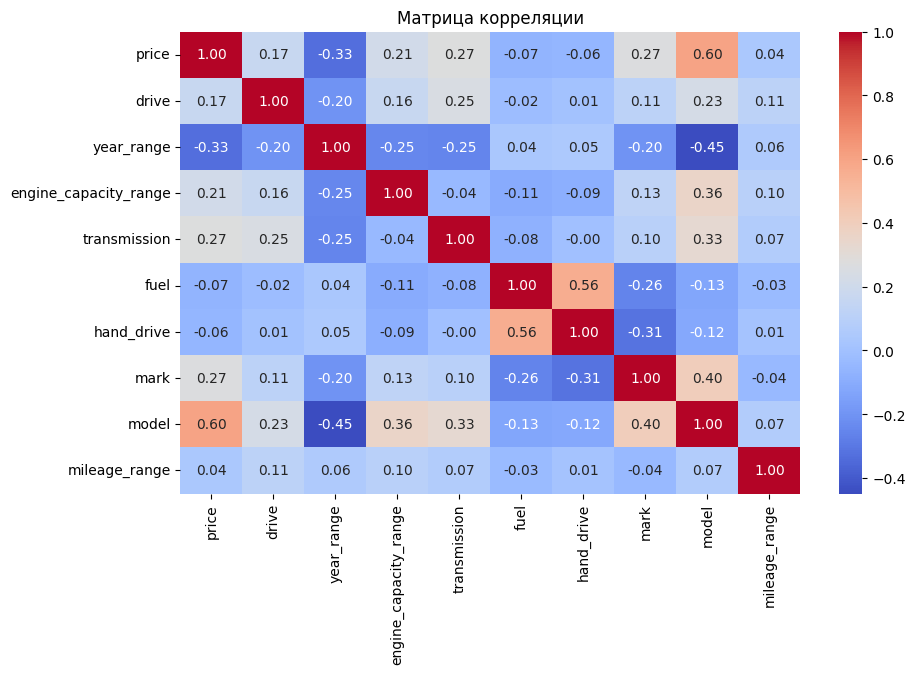

In [ ]:

from sklearn.preprocessing import LabelEncoder

for column in [ 'drive', 'hand_drive', 'fuel','transmission']:
    df[column] = LabelEncoder().fit_transform(df[column])


df.drop(['year','mileage','engine_capacity'],inplace=True, axis=1)

correlation_matrix = df[['price','drive', 'year_range','engine_capacity_range','transmission','fuel','hand_drive','mark','model','mileage_range']].corr()

# Извлечение корреляции от 'price'
print(correlation_matrix['price'])
# Визуализация матрицы корреляции
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

#Постобработка данных

In [ ]:
def new_data(list_columns, df, val_split, test_split):
    # Преобразуем категориальные переменные
    dataset = pd.concat([
        pd.get_dummies(df[col], prefix=col, drop_first=True, dtype=int) for col in list_columns
    ], axis=1)

    y = df.iloc[:, 0].values.reshape(-1, 1)
    x = dataset.values


    total_size = len(df)
    test_size = int(total_size * test_split)
    val_size = int(total_size * val_split)
    train_size = total_size - test_size - val_size

    x_train = x[:train_size]
    y_train = y[:train_size]

    x_val = x[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]

    x_test = x[train_size + val_size:]
    y_test = y[train_size + val_size:]

    return (np.array(x_train), np.array(y_train),
            np.array(x_val), np.array(y_val),
            np.array(x_test), np.array(y_test))

In [ ]:
columns_1= ['mileage_range','drive', 'year_range','engine_capacity_range','transmission','fuel','hand_drive','mark','model']

val_split = 0.1
test_split = 0.1

x_train_1, y_train, x_val_1, y_val, x_test_1, y_test = new_data(columns_1, df, val_split, test_split)

# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Q1 = df['price'].quantile(0.25)
# Q3 = df['price'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# y_train=np.clip(y_train, lower_bound, upper_bound)


# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)

In [ ]:
input = Input((x_train_1.shape[1],))


# Первый вход для числовых данных
x = input
x = Dense(1024, activation="relu")(x)
x= BatchNormalization()(x)
x = Dense(500, activation="relu")(x)
x = Dense(124, activation='relu')(x)
x = Dense(62, activation='relu')(x)
# x = Dropout(0.2)(x)

# Финальный регрессирующий нейрон
x = Dense(1, activation='linear')(x)

# В Model передаются входы и выход
model = Model((input), x)

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])
# 23

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, SpatialDropout1D, BatchNormalization, Dropout,GRU,LSTM,Reshape

model = Sequential()
model.add(Dense(1024, activation="relu",input_dim=x_train_1.shape[1]))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Reshape((1, 1024)))

# Два двунаправленных рекуррентных слоя LSTM
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Два рекуррентных слоя GRU
model.add(GRU(16, return_sequences=True, reset_after=True))
model.add(GRU(16, reset_after=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Дополнительный полносвязный слой
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))



model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
input = Input((x_train_1.shape[1],))


# Первый вход для числовых данных
x = input
x = Dense(1024, activation="relu")(x)
x= BatchNormalization()(x)
x = Dense(500, activation="relu")(x)
x = Dense(200, activation="relu")(x)
x = Dense(124, activation='relu')(x)
x = Dense(62, activation='relu')(x)
# x = Dropout(0.2)(x)

# Финальный регрессирующий нейрон
x = Dense(1, activation='linear')(x)

# В Model передаются входы и выход
model = Model((input), x)

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])
# 23

In [ ]:
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = './best_model.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0),
]
history = model.fit([x_train_1],
                           y_train_scaled,
                           batch_size=128,
                           epochs=100,
                           validation_data=([x_val_1], y_val_scaled),
                           verbose=1,callbacks=callbacks)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9184 - mae: 0.8040 - val_loss: 0.9839 - val_mae: 0.7981
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.8539 - mae: 0.7584 - val_loss: 0.9765 - val_mae: 0.7929
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7482 - mae: 0.6918 - val_loss: 0.9690 - val_mae: 0.7885
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6892 - mae: 0.6583 - val_loss: 0.9622 - val_mae: 0.7853
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6620 - mae: 0.6387 - val_loss: 0.9544 - val_mae: 0.7823
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6390 - mae: 0.6286 - val_loss: 0.9461 - val_mae: 0.7794
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6757 - mae: 0.6358 - val_loss: 0.9371 - val_mae: 0.7764
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6329 - mae: 0.6196 - val_loss: 0.9272 - val_mae: 0.7730
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - lo

#Результаты

In [ ]:
pred=model.predict([x_val_1])
pred = y_scaler.inverse_transform(pred)    # Обратная нормированию процедура


print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_val), '\n') # расчет средней абсолютной ошибки
print('Средний процент ошибки на тестовой выборке:', sum([abs(y_val[i, 0] - pred[i, 0])/y_val[i, 0]*100 for i in range(len(y_val))])/len(y_val),'%', '\n')

for i in range(10):
    print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f} (В процентах: {:6.2f})'.format(y_val[i, 0],
                                                                                                pred[i, 0],
                                                                                                abs(y_val[i, 0] - pred[i, 0]),abs(y_val[i, 0] - pred[i, 0])/y_val[i, 0]*100))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Средняя абсолютная ошибка: 71.30405865293561 

Средний процент ошибки на тестовой выборке: 9.762811722929468 % 

Реальное значение: 1008.00  Предсказанное значение: 966.78  Разница:  41.22 (В процентах:   4.09)
Реальное значение: 1008.00  Предсказанное значение: 951.84  Разница:  56.16 (В процентах:   5.57)
Реальное значение: 625.00  Предсказанное значение: 726.83  Разница: 101.83 (В процентах:  16.29)
Реальное значение: 900.00  Предсказанное значение: 800.76  Разница:  99.24 (В процентах:  11.03)
Реальное значение: 850.00  Предсказанное значение: 877.94  Разница:  27.94 (В процентах:   3.29)
Реальное значение: 1008.00  Предсказанное значение: 972.53  Разница:  35.47 (В процентах:   3.52)
Реальное значение: 1008.00  Предсказанное значение: 940.33  Разница:  67.67 (В процентах:   6.71)
Реальное значение: 750.00  Предсказанное значение: 826.17  Разница:  76.17 (В процентах:  10.16)
Реальное значение: 526.00  Предсказанное значение: 759.19  Разница: 2